# Assignment 03: CLIP zero-shot prediction


### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST  # 修改此行
from torchvision import datasets
from torchvision import transforms
import torchvision

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from PIL import Image
from clip import clip

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Hyperparameters

In [2]:
# # random seed
# SEED = 1 
# NUM_CLASS = 10

# Training
BATCH_SIZE = 128
# NUM_EPOCHS = 30
# EVAL_INTERVAL=1
# SAVE_DIR = './log'

# # Optimizer
# LEARNING_RATE = 1e-1
# MOMENTUM = 0.9
# STEP=5
# GAMMA=0.5

# CLIP
VISUAL_BACKBONE = 'RN50' # RN50, ViT-B/32, ViT-B/16


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


#### cifar10

transform_cifar10_test = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_set = torchvision.datasets.CIFAR10(root='/shareddata', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dataset_name = 'CIFAR10'

#### mnist

In [4]:


transform_mnist_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  
    transforms.Resize(size=(224, 224)),
     transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # 根据MNIST的均值和标准差进行归一化
])

test_set = torchvision.datasets.MNIST(root='/shareddata', train=False,
                                      download=True, transform=transform_mnist_test)


test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                              shuffle=False, num_workers=2)


class_names = [str(i) for i in range(10)]
dataset_name = 'MNIST'



### Model

In [5]:
# Load the model

model, preprocess = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/data/home/wsy/.cache/clip/')

model.to(device)

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

### Encode text

In [6]:
prompt = "asdqwedqwdwda"

text_inputs = torch.cat([clip.tokenize(f"{prompt} {c}") for c in class_names]).to(device)

### Task 1: Prompt Gereration
---

Please denfine a function named ``prompt_encode`` to encode the text using CLIP text encoder.


In [7]:
def model_inference(model, image):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    
    image_features = model.encode_image(image)
    text_features = model.encode_text(text_inputs)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    logit_scale = model.logit_scale.exp()

    logits = logit_scale * image_features @ text_features.t()

    ###############################################################

    return logits

### Task 2: Zero-shot inference
---

Please denfine a function named ``model_inference``. The function is essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Encode the image.
2. Encode the text.
3. Calculate the logits.

In [8]:
testing_loss = []
testing_acc = []

# 添加以下代码以定义MNIST测试数据加载器
test_dataloader_mnist = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# 在模型评估部分使用test_dataloader_mnist
with torch.no_grad():
    model.eval()

    val_loss = 0.0
    val_corrects = 0

    for batch_idx, (image, target) in enumerate(test_dataloader_mnist):  # 修改此行

        image = image.to(device)
        target = target.to(device)

        # test model
        logits = model_inference(model, image)
        _, preds = torch.max(logits, 1)
        
        val_corrects += torch.sum(preds == target.data)

    val_acc = val_corrects.double() / len(test_set)

    print(f"the zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")

the zero-shot performance on MNIST is 37.33%, visual encoder is RN50.


In [9]:
from sklearn.metrics import confusion_matrix, classification_report


y_true = []
y_pred = []

with torch.no_grad():
    model.eval()

    for batch_idx, (image, target) in enumerate(test_dataloader_mnist):
        image = image.to(device)
        target = target.to(device)

        logits = model_inference(model, image)
        _, preds = torch.max(logits, 1)

        y_true += target.cpu().numpy().tolist()
        y_pred += preds.cpu().numpy().tolist()

conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=class_names)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

class_report = classification_report(y_true, y_pred, target_names=class_names, zero_division=1)

Confusion Matrix:
[[  0   0 436 172 119  16  21 124   0  92]
 [  0   0 141 806 155   0   1  32   0   0]
 [  0   0 334 411 114  47   8 116   0   2]
 [  0   0  30 888  31  33   2  23   0   3]
 [  0   0  24  70 772   0   0 114   0   2]
 [  0   0  48  64  16 737  16  11   0   0]
 [  0   0  83  93 232 446  37  61   0   6]
 [  0   0  74 147 124  21   1 661   0   0]
 [  0   0  78 382  44  25  57  44   8 336]
 [  0   0  75 105  94   3   0 436   0 296]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.25      0.32      0.28      1032
           3       0.28      0.88      0.43      1010
           4       0.45      0.79      0.58       982
           5       0.55      0.83      0.66       892
           6       0.26      0.04      0.07       958
           7       0.41      0.64      0.50      1028
           8       1.00      0.01      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
# 在模型评估部分添加以下代码
testing_loss = []

with torch.no_grad():
    model.eval()

    for batch_idx, (image, target) in enumerate(test_dataloader_mnist):
        image = image.to(device)
        target = target.to(device)

        logits = model_inference(model, image)

        # 计算交叉熵损失
        loss = F.cross_entropy(logits, target)
        testing_loss.append(loss.item())

average_loss = np.mean(testing_loss)
print(f"Average Loss on Test Set: {average_loss}")

Average Loss on Test Set: 2.1269778481012658


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


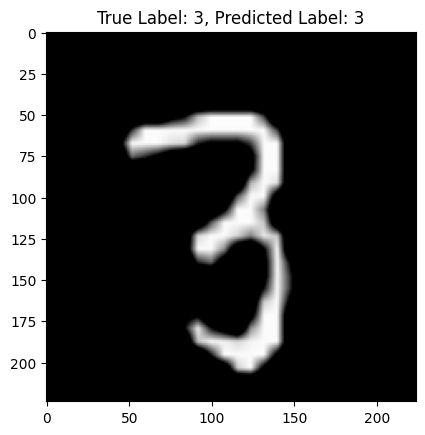

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


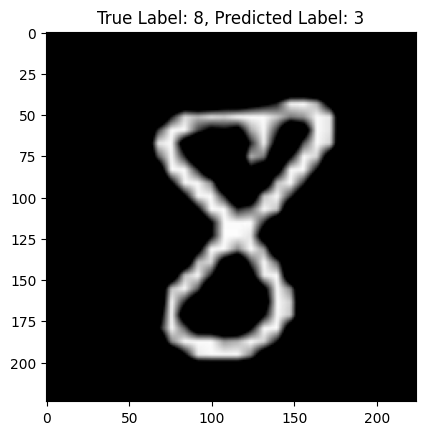

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


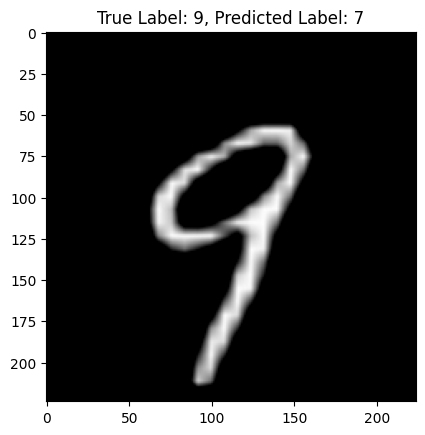

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


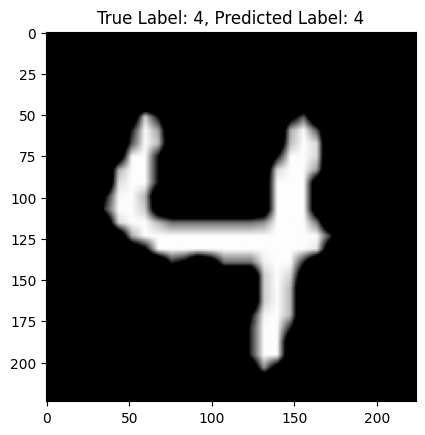

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


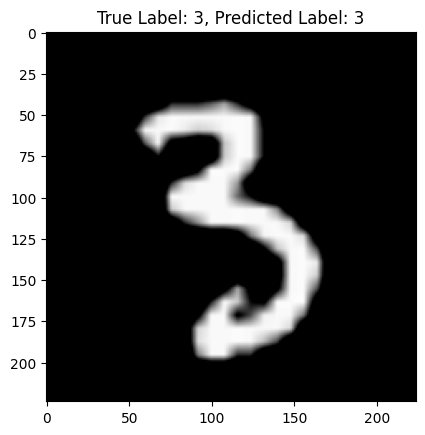

In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt

model.eval()

num_visualizations = 5 

for _ in range(num_visualizations):
    idx = random.randint(0, len(test_set)-1)
    image, target = test_set[idx]

    image_tensor = image.unsqueeze(0).to(device)

    logits = model_inference(model, image_tensor)
    _, pred = torch.max(logits, 1)

    image_np = np.transpose(image.numpy(), (1, 2, 0))

    plt.imshow(image_np)
    plt.title(f"True Label: {class_names[target]}, Predicted Label: {class_names[pred.item()]}")

    # 保存图像
    plt.savefig(f'visualization_1{_+1}.png')  # 保存为不同的文件名

    plt.show()
